In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

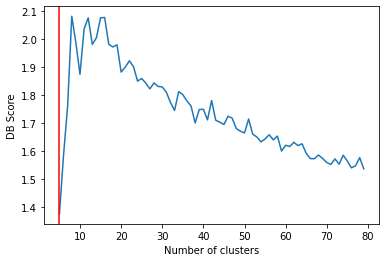

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

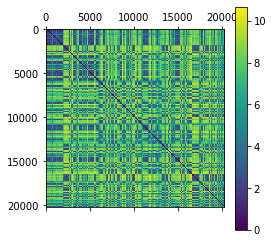

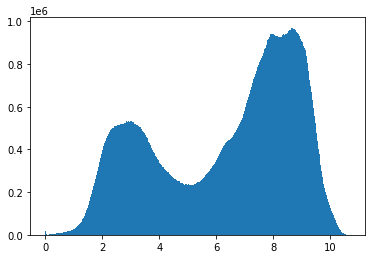

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

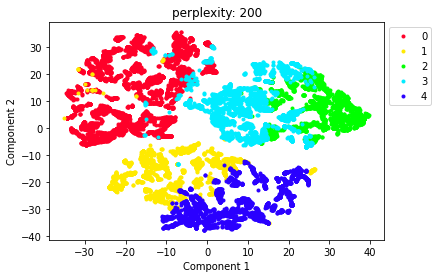

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 6

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.8547282314098458


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.9418574059458039
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.590 | Reg loss: 0.013 | Tree loss: 1.590 | Accuracy: 0.380500 | 0.374 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.571 | Reg loss: 0.013 | Tree loss: 1.571 | Accuracy: 0.432000 | 0.227 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.013 | Tree loss: 1.555 | Accuracy: 0.401500 | 0.176 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.541 | Reg loss: 0.013 | Tree loss: 1.541 | Accuracy: 0.377500 | 0.152 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.530 | Reg loss: 0.013 | Tree loss: 1.530 | Accuracy: 0.374000 | 0.137 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.518 | Reg loss: 0.013 | Tree loss: 1.518 | Accuracy: 0.362500 | 0.127 sec/iter
Epoch: 00 | Batch: 006 / 011 | Total loss: 1.512 | Reg loss: 0.013 | Tree loss: 1.

Epoch: 05 | Batch: 003 / 011 | Total loss: 1.456 | Reg loss: 0.014 | Tree loss: 1.456 | Accuracy: 0.464000 | 0.108 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.440 | Reg loss: 0.014 | Tree loss: 1.440 | Accuracy: 0.453000 | 0.107 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.431 | Reg loss: 0.014 | Tree loss: 1.431 | Accuracy: 0.433500 | 0.107 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 1.424 | Reg loss: 0.014 | Tree loss: 1.424 | Accuracy: 0.413500 | 0.106 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 1.401 | Reg loss: 0.015 | Tree loss: 1.401 | Accuracy: 0.441500 | 0.106 sec/iter
Epoch: 05 | Batch: 008 / 011 | Total loss: 1.399 | Reg loss: 0.015 | Tree loss: 1.399 | Accuracy: 0.433000 | 0.105 sec/iter
Epoch: 05 | Batch: 009 / 011 | Total loss: 1.390 | Reg loss: 0.015 | Tree loss: 1.390 | Accuracy: 0.438000 | 0.105 sec/iter
Epoch: 05 | Batch: 010 / 011 | Total loss: 1.361 | Reg loss: 0.015 | Tree loss: 1.361 | Accuracy: 0.457338 | 0.104 sec/iter
Average 

Epoch: 10 | Batch: 007 / 011 | Total loss: 1.294 | Reg loss: 0.018 | Tree loss: 1.294 | Accuracy: 0.498500 | 0.116 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.271 | Reg loss: 0.018 | Tree loss: 1.271 | Accuracy: 0.508500 | 0.115 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.262 | Reg loss: 0.019 | Tree loss: 1.262 | Accuracy: 0.513000 | 0.115 sec/iter
Epoch: 10 | Batch: 010 / 011 | Total loss: 1.271 | Reg loss: 0.019 | Tree loss: 1.271 | Accuracy: 0.494881 | 0.114 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 11 | Batch: 000 / 011 | Total loss: 1.366 | Reg loss: 0.018 | Tree loss: 1.366 | Accuracy: 0.494000 | 0.114 sec/iter
Epoch: 11 | Batch: 001 / 011 | Total loss: 1.356 | Reg loss: 0.018 | Tree loss: 1.356 | Accuracy: 0.518000 | 0.114 sec/iter
Epoch: 11 | Batch: 002 / 011 | Total loss: 1.343 | Reg loss: 0.018 | Tree los

Epoch: 16 | Batch: 002 / 011 | Total loss: 1.254 | Reg loss: 0.021 | Tree loss: 1.254 | Accuracy: 0.575000 | 0.101 sec/iter
Epoch: 16 | Batch: 003 / 011 | Total loss: 1.239 | Reg loss: 0.021 | Tree loss: 1.239 | Accuracy: 0.579500 | 0.101 sec/iter
Epoch: 16 | Batch: 004 / 011 | Total loss: 1.202 | Reg loss: 0.022 | Tree loss: 1.202 | Accuracy: 0.591000 | 0.101 sec/iter
Epoch: 16 | Batch: 005 / 011 | Total loss: 1.199 | Reg loss: 0.022 | Tree loss: 1.199 | Accuracy: 0.565000 | 0.1 sec/iter
Epoch: 16 | Batch: 006 / 011 | Total loss: 1.198 | Reg loss: 0.022 | Tree loss: 1.198 | Accuracy: 0.560000 | 0.1 sec/iter
Epoch: 16 | Batch: 007 / 011 | Total loss: 1.188 | Reg loss: 0.022 | Tree loss: 1.188 | Accuracy: 0.557000 | 0.1 sec/iter
Epoch: 16 | Batch: 008 / 011 | Total loss: 1.173 | Reg loss: 0.022 | Tree loss: 1.173 | Accuracy: 0.554000 | 0.1 sec/iter
Epoch: 16 | Batch: 009 / 011 | Total loss: 1.151 | Reg loss: 0.022 | Tree loss: 1.151 | Accuracy: 0.562500 | 0.1 sec/iter
Epoch: 16 | Batch:

Epoch: 21 | Batch: 009 / 011 | Total loss: 1.093 | Reg loss: 0.025 | Tree loss: 1.093 | Accuracy: 0.562500 | 0.103 sec/iter
Epoch: 21 | Batch: 010 / 011 | Total loss: 1.119 | Reg loss: 0.025 | Tree loss: 1.119 | Accuracy: 0.535836 | 0.103 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 22 | Batch: 000 / 011 | Total loss: 1.198 | Reg loss: 0.024 | Tree loss: 1.198 | Accuracy: 0.550000 | 0.105 sec/iter
Epoch: 22 | Batch: 001 / 011 | Total loss: 1.185 | Reg loss: 0.025 | Tree loss: 1.185 | Accuracy: 0.578500 | 0.105 sec/iter
Epoch: 22 | Batch: 002 / 011 | Total loss: 1.167 | Reg loss: 0.025 | Tree loss: 1.167 | Accuracy: 0.582500 | 0.105 sec/iter
Epoch: 22 | Batch: 003 / 011 | Total loss: 1.144 | Reg loss: 0.025 | Tree loss: 1.144 | Accuracy: 0.582000 | 0.104 sec/iter
Epoch: 22 | Batch: 004 / 011 | Total loss: 1.129 | Reg loss: 0.025 | Tree los

Epoch: 27 | Batch: 003 / 011 | Total loss: 1.092 | Reg loss: 0.026 | Tree loss: 1.092 | Accuracy: 0.576500 | 0.106 sec/iter
Epoch: 27 | Batch: 004 / 011 | Total loss: 1.061 | Reg loss: 0.027 | Tree loss: 1.061 | Accuracy: 0.586500 | 0.105 sec/iter
Epoch: 27 | Batch: 005 / 011 | Total loss: 1.089 | Reg loss: 0.027 | Tree loss: 1.089 | Accuracy: 0.563500 | 0.105 sec/iter
Epoch: 27 | Batch: 006 / 011 | Total loss: 1.048 | Reg loss: 0.027 | Tree loss: 1.048 | Accuracy: 0.596500 | 0.105 sec/iter
Epoch: 27 | Batch: 007 / 011 | Total loss: 1.037 | Reg loss: 0.027 | Tree loss: 1.037 | Accuracy: 0.599000 | 0.105 sec/iter
Epoch: 27 | Batch: 008 / 011 | Total loss: 1.031 | Reg loss: 0.027 | Tree loss: 1.031 | Accuracy: 0.563500 | 0.105 sec/iter
Epoch: 27 | Batch: 009 / 011 | Total loss: 1.037 | Reg loss: 0.027 | Tree loss: 1.037 | Accuracy: 0.569000 | 0.105 sec/iter
Epoch: 27 | Batch: 010 / 011 | Total loss: 1.004 | Reg loss: 0.027 | Tree loss: 1.004 | Accuracy: 0.580205 | 0.105 sec/iter
Average 

Epoch: 32 | Batch: 008 / 011 | Total loss: 0.989 | Reg loss: 0.028 | Tree loss: 0.989 | Accuracy: 0.584500 | 0.105 sec/iter
Epoch: 32 | Batch: 009 / 011 | Total loss: 0.998 | Reg loss: 0.028 | Tree loss: 0.998 | Accuracy: 0.569500 | 0.105 sec/iter
Epoch: 32 | Batch: 010 / 011 | Total loss: 0.946 | Reg loss: 0.028 | Tree loss: 0.946 | Accuracy: 0.600683 | 0.104 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 33 | Batch: 000 / 011 | Total loss: 1.085 | Reg loss: 0.028 | Tree loss: 1.085 | Accuracy: 0.595000 | 0.106 sec/iter
Epoch: 33 | Batch: 001 / 011 | Total loss: 1.069 | Reg loss: 0.028 | Tree loss: 1.069 | Accuracy: 0.586000 | 0.106 sec/iter
Epoch: 33 | Batch: 002 / 011 | Total loss: 1.060 | Reg loss: 0.028 | Tree loss: 1.060 | Accuracy: 0.592000 | 0.106 sec/iter
Epoch: 33 | Batch: 003 / 011 | Total loss: 1.074 | Reg loss: 0.028 | Tree los

Epoch: 38 | Batch: 001 / 011 | Total loss: 1.047 | Reg loss: 0.028 | Tree loss: 1.047 | Accuracy: 0.573500 | 0.107 sec/iter
Epoch: 38 | Batch: 002 / 011 | Total loss: 1.042 | Reg loss: 0.029 | Tree loss: 1.042 | Accuracy: 0.574000 | 0.107 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 0.997 | Reg loss: 0.029 | Tree loss: 0.997 | Accuracy: 0.614000 | 0.107 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 0.974 | Reg loss: 0.029 | Tree loss: 0.974 | Accuracy: 0.629500 | 0.107 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 0.975 | Reg loss: 0.029 | Tree loss: 0.975 | Accuracy: 0.614000 | 0.107 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.963 | Reg loss: 0.029 | Tree loss: 0.963 | Accuracy: 0.615000 | 0.107 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.971 | Reg loss: 0.029 | Tree loss: 0.971 | Accuracy: 0.578500 | 0.107 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.977 | Reg loss: 0.029 | Tree loss: 0.977 | Accuracy: 0.572000 | 0.107 sec/iter
Epoch: 3

Epoch: 43 | Batch: 006 / 011 | Total loss: 0.956 | Reg loss: 0.029 | Tree loss: 0.956 | Accuracy: 0.615000 | 0.108 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 0.940 | Reg loss: 0.029 | Tree loss: 0.940 | Accuracy: 0.620500 | 0.108 sec/iter
Epoch: 43 | Batch: 008 / 011 | Total loss: 0.939 | Reg loss: 0.029 | Tree loss: 0.939 | Accuracy: 0.610500 | 0.108 sec/iter
Epoch: 43 | Batch: 009 / 011 | Total loss: 0.926 | Reg loss: 0.029 | Tree loss: 0.926 | Accuracy: 0.598500 | 0.108 sec/iter
Epoch: 43 | Batch: 010 / 011 | Total loss: 0.912 | Reg loss: 0.029 | Tree loss: 0.912 | Accuracy: 0.576792 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 44 | Batch: 000 / 011 | Total loss: 1.040 | Reg loss: 0.029 | Tree loss: 1.040 | Accuracy: 0.580000 | 0.109 sec/iter
Epoch: 44 | Batch: 001 / 011 | Total loss: 1.014 | Reg loss: 0.029 | Tree los

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 49 | Batch: 000 / 011 | Total loss: 1.005 | Reg loss: 0.029 | Tree loss: 1.005 | Accuracy: 0.593000 | 0.109 sec/iter
Epoch: 49 | Batch: 001 / 011 | Total loss: 1.029 | Reg loss: 0.029 | Tree loss: 1.029 | Accuracy: 0.582000 | 0.109 sec/iter
Epoch: 49 | Batch: 002 / 011 | Total loss: 0.992 | Reg loss: 0.029 | Tree loss: 0.992 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 49 | Batch: 003 / 011 | Total loss: 1.004 | Reg loss: 0.029 | Tree loss: 1.004 | Accuracy: 0.592000 | 0.109 sec/iter
Epoch: 49 | Batch: 004 / 011 | Total loss: 0.979 | Reg loss: 0.030 | Tree loss: 0.979 | Accuracy: 0.611000 | 0.109 sec/iter
Epoch: 49 | Batch: 005 / 011 | Total loss: 0.973 | Reg loss: 0.030 | Tree loss: 0.973 | Accuracy: 0.590500 | 0.109 sec/iter
Epoch: 49 | Batch: 006 / 011 | Total loss: 0.949 | Reg loss: 0.030 | Tree los

Epoch: 54 | Batch: 004 / 011 | Total loss: 0.956 | Reg loss: 0.030 | Tree loss: 0.956 | Accuracy: 0.623000 | 0.108 sec/iter
Epoch: 54 | Batch: 005 / 011 | Total loss: 0.927 | Reg loss: 0.030 | Tree loss: 0.927 | Accuracy: 0.611500 | 0.108 sec/iter
Epoch: 54 | Batch: 006 / 011 | Total loss: 0.932 | Reg loss: 0.030 | Tree loss: 0.932 | Accuracy: 0.624000 | 0.108 sec/iter
Epoch: 54 | Batch: 007 / 011 | Total loss: 0.909 | Reg loss: 0.030 | Tree loss: 0.909 | Accuracy: 0.618000 | 0.108 sec/iter
Epoch: 54 | Batch: 008 / 011 | Total loss: 0.910 | Reg loss: 0.030 | Tree loss: 0.910 | Accuracy: 0.598500 | 0.108 sec/iter
Epoch: 54 | Batch: 009 / 011 | Total loss: 0.915 | Reg loss: 0.030 | Tree loss: 0.915 | Accuracy: 0.586500 | 0.108 sec/iter
Epoch: 54 | Batch: 010 / 011 | Total loss: 0.910 | Reg loss: 0.030 | Tree loss: 0.910 | Accuracy: 0.576792 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 

Epoch: 59 | Batch: 009 / 011 | Total loss: 0.911 | Reg loss: 0.030 | Tree loss: 0.911 | Accuracy: 0.573000 | 0.109 sec/iter
Epoch: 59 | Batch: 010 / 011 | Total loss: 0.897 | Reg loss: 0.030 | Tree loss: 0.897 | Accuracy: 0.576792 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 60 | Batch: 000 / 011 | Total loss: 0.991 | Reg loss: 0.030 | Tree loss: 0.991 | Accuracy: 0.586000 | 0.11 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.991 | Reg loss: 0.030 | Tree loss: 0.991 | Accuracy: 0.592000 | 0.11 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.030 | Tree loss: 0.966 | Accuracy: 0.612000 | 0.11 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.949 | Reg loss: 0.030 | Tree loss: 0.949 | Accuracy: 0.625500 | 0.109 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.942 | Reg loss: 0.030 | Tree loss: 

Epoch: 65 | Batch: 003 / 011 | Total loss: 0.949 | Reg loss: 0.030 | Tree loss: 0.949 | Accuracy: 0.602500 | 0.11 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.929 | Reg loss: 0.030 | Tree loss: 0.929 | Accuracy: 0.630500 | 0.11 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.931 | Reg loss: 0.030 | Tree loss: 0.931 | Accuracy: 0.620000 | 0.11 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 0.899 | Reg loss: 0.030 | Tree loss: 0.899 | Accuracy: 0.622500 | 0.11 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 0.868 | Reg loss: 0.030 | Tree loss: 0.868 | Accuracy: 0.624500 | 0.109 sec/iter
Epoch: 65 | Batch: 008 / 011 | Total loss: 0.892 | Reg loss: 0.030 | Tree loss: 0.892 | Accuracy: 0.610000 | 0.109 sec/iter
Epoch: 65 | Batch: 009 / 011 | Total loss: 0.912 | Reg loss: 0.030 | Tree loss: 0.912 | Accuracy: 0.570000 | 0.109 sec/iter
Epoch: 65 | Batch: 010 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.604096 | 0.109 sec/iter
Average spar

Epoch: 70 | Batch: 009 / 011 | Total loss: 0.896 | Reg loss: 0.030 | Tree loss: 0.896 | Accuracy: 0.565500 | 0.109 sec/iter
Epoch: 70 | Batch: 010 / 011 | Total loss: 0.864 | Reg loss: 0.030 | Tree loss: 0.864 | Accuracy: 0.559727 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 71 | Batch: 000 / 011 | Total loss: 0.972 | Reg loss: 0.030 | Tree loss: 0.972 | Accuracy: 0.593000 | 0.11 sec/iter
Epoch: 71 | Batch: 001 / 011 | Total loss: 0.965 | Reg loss: 0.030 | Tree loss: 0.965 | Accuracy: 0.596500 | 0.11 sec/iter
Epoch: 71 | Batch: 002 / 011 | Total loss: 0.959 | Reg loss: 0.030 | Tree loss: 0.959 | Accuracy: 0.591500 | 0.109 sec/iter
Epoch: 71 | Batch: 003 / 011 | Total loss: 0.942 | Reg loss: 0.030 | Tree loss: 0.942 | Accuracy: 0.627000 | 0.109 sec/iter
Epoch: 71 | Batch: 004 / 011 | Total loss: 0.943 | Reg loss: 0.030 | Tree loss:

Epoch: 76 | Batch: 003 / 011 | Total loss: 0.920 | Reg loss: 0.030 | Tree loss: 0.920 | Accuracy: 0.613500 | 0.109 sec/iter
Epoch: 76 | Batch: 004 / 011 | Total loss: 0.911 | Reg loss: 0.030 | Tree loss: 0.911 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 76 | Batch: 005 / 011 | Total loss: 0.895 | Reg loss: 0.030 | Tree loss: 0.895 | Accuracy: 0.634500 | 0.109 sec/iter
Epoch: 76 | Batch: 006 / 011 | Total loss: 0.886 | Reg loss: 0.030 | Tree loss: 0.886 | Accuracy: 0.619500 | 0.109 sec/iter
Epoch: 76 | Batch: 007 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 76 | Batch: 008 / 011 | Total loss: 0.902 | Reg loss: 0.030 | Tree loss: 0.902 | Accuracy: 0.575000 | 0.109 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.878 | Reg loss: 0.030 | Tree loss: 0.878 | Accuracy: 0.595500 | 0.109 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.901 | Reg loss: 0.031 | Tree loss: 0.901 | Accuracy: 0.566553 | 0.109 sec/iter
Average 

Epoch: 81 | Batch: 009 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.590500 | 0.11 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 0.867 | Reg loss: 0.031 | Tree loss: 0.867 | Accuracy: 0.583618 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 82 | Batch: 000 / 011 | Total loss: 0.974 | Reg loss: 0.030 | Tree loss: 0.974 | Accuracy: 0.593000 | 0.11 sec/iter
Epoch: 82 | Batch: 001 / 011 | Total loss: 0.982 | Reg loss: 0.030 | Tree loss: 0.982 | Accuracy: 0.588500 | 0.11 sec/iter
Epoch: 82 | Batch: 002 / 011 | Total loss: 0.936 | Reg loss: 0.030 | Tree loss: 0.936 | Accuracy: 0.615500 | 0.11 sec/iter
Epoch: 82 | Batch: 003 / 011 | Total loss: 0.911 | Reg loss: 0.030 | Tree loss: 0.911 | Accuracy: 0.621000 | 0.11 sec/iter
Epoch: 82 | Batch: 004 / 011 | Total loss: 0.905 | Reg loss: 0.030 | Tree loss: 0.9

Epoch: 87 | Batch: 003 / 011 | Total loss: 0.913 | Reg loss: 0.030 | Tree loss: 0.913 | Accuracy: 0.612500 | 0.11 sec/iter
Epoch: 87 | Batch: 004 / 011 | Total loss: 0.897 | Reg loss: 0.030 | Tree loss: 0.897 | Accuracy: 0.624500 | 0.11 sec/iter
Epoch: 87 | Batch: 005 / 011 | Total loss: 0.892 | Reg loss: 0.030 | Tree loss: 0.892 | Accuracy: 0.623000 | 0.11 sec/iter
Epoch: 87 | Batch: 006 / 011 | Total loss: 0.884 | Reg loss: 0.030 | Tree loss: 0.884 | Accuracy: 0.620500 | 0.109 sec/iter
Epoch: 87 | Batch: 007 / 011 | Total loss: 0.881 | Reg loss: 0.030 | Tree loss: 0.881 | Accuracy: 0.609500 | 0.109 sec/iter
Epoch: 87 | Batch: 008 / 011 | Total loss: 0.878 | Reg loss: 0.030 | Tree loss: 0.878 | Accuracy: 0.591500 | 0.109 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 0.885 | Reg loss: 0.030 | Tree loss: 0.885 | Accuracy: 0.569000 | 0.109 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.870 | Reg loss: 0.031 | Tree loss: 0.870 | Accuracy: 0.593857 | 0.109 sec/iter
Average spa

Epoch: 92 | Batch: 008 / 011 | Total loss: 0.876 | Reg loss: 0.030 | Tree loss: 0.876 | Accuracy: 0.584000 | 0.109 sec/iter
Epoch: 92 | Batch: 009 / 011 | Total loss: 0.891 | Reg loss: 0.030 | Tree loss: 0.891 | Accuracy: 0.565500 | 0.109 sec/iter
Epoch: 92 | Batch: 010 / 011 | Total loss: 0.839 | Reg loss: 0.031 | Tree loss: 0.839 | Accuracy: 0.573379 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.941 | Reg loss: 0.030 | Tree loss: 0.941 | Accuracy: 0.596000 | 0.109 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.954 | Reg loss: 0.030 | Tree loss: 0.954 | Accuracy: 0.592000 | 0.109 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.936 | Reg loss: 0.030 | Tree loss: 0.936 | Accuracy: 0.604000 | 0.109 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.929 | Reg loss: 0.030 | Tree los

Epoch: 98 | Batch: 000 / 011 | Total loss: 0.957 | Reg loss: 0.030 | Tree loss: 0.957 | Accuracy: 0.597000 | 0.107 sec/iter
Epoch: 98 | Batch: 001 / 011 | Total loss: 0.940 | Reg loss: 0.030 | Tree loss: 0.940 | Accuracy: 0.610000 | 0.107 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.910 | Reg loss: 0.030 | Tree loss: 0.910 | Accuracy: 0.622500 | 0.107 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.900 | Reg loss: 0.030 | Tree loss: 0.900 | Accuracy: 0.624000 | 0.107 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.906 | Reg loss: 0.030 | Tree loss: 0.906 | Accuracy: 0.620500 | 0.107 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.876 | Reg loss: 0.030 | Tree loss: 0.876 | Accuracy: 0.630500 | 0.107 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.866 | Reg loss: 0.030 | Tree loss: 0.866 | Accuracy: 0.612000 | 0.107 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.868 | Reg loss: 0.030 | Tree loss: 0.868 | Accuracy: 0.581500 | 0.107 sec/iter
Epoch: 9

Epoch: 103 | Batch: 007 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.614000 | 0.108 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.846 | Reg loss: 0.030 | Tree loss: 0.846 | Accuracy: 0.630000 | 0.108 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.865 | Reg loss: 0.030 | Tree loss: 0.865 | Accuracy: 0.597500 | 0.108 sec/iter
Epoch: 103 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.030 | Tree loss: 0.857 | Accuracy: 0.569966 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 104 | Batch: 000 / 011 | Total loss: 0.935 | Reg loss: 0.030 | Tree loss: 0.935 | Accuracy: 0.604000 | 0.108 sec/iter
Epoch: 104 | Batch: 001 / 011 | Total loss: 0.931 | Reg loss: 0.030 | Tree loss: 0.931 | Accuracy: 0.615500 | 0.108 sec/iter
Epoch: 104 | Batch: 002 / 011 | Total loss: 0.911 | Reg loss: 0.030 | T

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 109 | Batch: 000 / 011 | Total loss: 0.926 | Reg loss: 0.030 | Tree loss: 0.926 | Accuracy: 0.613000 | 0.108 sec/iter
Epoch: 109 | Batch: 001 / 011 | Total loss: 0.927 | Reg loss: 0.030 | Tree loss: 0.927 | Accuracy: 0.613000 | 0.108 sec/iter
Epoch: 109 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.030 | Tree loss: 0.883 | Accuracy: 0.634000 | 0.108 sec/iter
Epoch: 109 | Batch: 003 / 011 | Total loss: 0.917 | Reg loss: 0.030 | Tree loss: 0.917 | Accuracy: 0.617000 | 0.108 sec/iter
Epoch: 109 | Batch: 004 / 011 | Total loss: 0.870 | Reg loss: 0.030 | Tree loss: 0.870 | Accuracy: 0.642000 | 0.108 sec/iter
Epoch: 109 | Batch: 005 / 011 | Total loss: 0.879 | Reg loss: 0.030 | Tree loss: 0.879 | Accuracy: 0.624500 | 0.108 sec/iter
Epoch: 109 | Batch: 006 / 011 | Total loss: 0.864 | Reg loss: 0.030 | T

Epoch: 114 | Batch: 003 / 011 | Total loss: 0.902 | Reg loss: 0.030 | Tree loss: 0.902 | Accuracy: 0.614000 | 0.108 sec/iter
Epoch: 114 | Batch: 004 / 011 | Total loss: 0.875 | Reg loss: 0.030 | Tree loss: 0.875 | Accuracy: 0.624000 | 0.108 sec/iter
Epoch: 114 | Batch: 005 / 011 | Total loss: 0.873 | Reg loss: 0.030 | Tree loss: 0.873 | Accuracy: 0.615000 | 0.108 sec/iter
Epoch: 114 | Batch: 006 / 011 | Total loss: 0.843 | Reg loss: 0.030 | Tree loss: 0.843 | Accuracy: 0.647500 | 0.108 sec/iter
Epoch: 114 | Batch: 007 / 011 | Total loss: 0.856 | Reg loss: 0.030 | Tree loss: 0.856 | Accuracy: 0.628000 | 0.108 sec/iter
Epoch: 114 | Batch: 008 / 011 | Total loss: 0.881 | Reg loss: 0.030 | Tree loss: 0.881 | Accuracy: 0.595500 | 0.108 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 0.856 | Reg loss: 0.030 | Tree loss: 0.856 | Accuracy: 0.618000 | 0.108 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 0.806 | Reg loss: 0.030 | Tree loss: 0.806 | Accuracy: 0.610922 | 0.108 sec/iter


Epoch: 119 | Batch: 010 / 011 | Total loss: 0.918 | Reg loss: 0.030 | Tree loss: 0.918 | Accuracy: 0.532423 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.917 | Reg loss: 0.030 | Tree loss: 0.917 | Accuracy: 0.608500 | 0.108 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.924 | Reg loss: 0.030 | Tree loss: 0.924 | Accuracy: 0.613000 | 0.108 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.030 | Tree loss: 0.894 | Accuracy: 0.625000 | 0.108 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.887 | Reg loss: 0.030 | Tree loss: 0.887 | Accuracy: 0.614000 | 0.108 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.894 | Reg loss: 0.030 | Tree loss: 0.894 | Accuracy: 0.616000 | 0.108 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 0.870 | Reg loss: 0.030 | T

Epoch: 125 | Batch: 003 / 011 | Total loss: 0.872 | Reg loss: 0.030 | Tree loss: 0.872 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.851 | Reg loss: 0.030 | Tree loss: 0.851 | Accuracy: 0.624500 | 0.109 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.578500 | 0.109 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 0.869 | Reg loss: 0.030 | Tree loss: 0.869 | Accuracy: 0.604000 | 0.109 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 0.845 | Reg loss: 0.030 | Tree loss: 0.845 | Accuracy: 0.621000 | 0.109 sec/iter
Epoch: 125 | Batch: 008 / 011 | Total loss: 0.880 | Reg loss: 0.030 | Tree loss: 0.880 | Accuracy: 0.605000 | 0.109 sec/iter
Epoch: 125 | Batch: 009 / 011 | Total loss: 0.871 | Reg loss: 0.030 | Tree loss: 0.871 | Accuracy: 0.618000 | 0.109 sec/iter
Epoch: 125 | Batch: 010 / 011 | Total loss: 0.883 | Reg loss: 0.030 | Tree loss: 0.883 | Accuracy: 0.600683 | 0.109 sec/iter


Epoch: 130 | Batch: 009 / 011 | Total loss: 0.873 | Reg loss: 0.030 | Tree loss: 0.873 | Accuracy: 0.615000 | 0.108 sec/iter
Epoch: 130 | Batch: 010 / 011 | Total loss: 0.861 | Reg loss: 0.030 | Tree loss: 0.861 | Accuracy: 0.607509 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 131 | Batch: 000 / 011 | Total loss: 0.931 | Reg loss: 0.030 | Tree loss: 0.931 | Accuracy: 0.577000 | 0.109 sec/iter
Epoch: 131 | Batch: 001 / 011 | Total loss: 0.906 | Reg loss: 0.030 | Tree loss: 0.906 | Accuracy: 0.610000 | 0.109 sec/iter
Epoch: 131 | Batch: 002 / 011 | Total loss: 0.908 | Reg loss: 0.030 | Tree loss: 0.908 | Accuracy: 0.617000 | 0.109 sec/iter
Epoch: 131 | Batch: 003 / 011 | Total loss: 0.871 | Reg loss: 0.030 | Tree loss: 0.871 | Accuracy: 0.633000 | 0.109 sec/iter
Epoch: 131 | Batch: 004 / 011 | Total loss: 0.887 | Reg loss: 0.030 | T

Epoch: 136 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.030 | Tree loss: 0.898 | Accuracy: 0.612500 | 0.109 sec/iter
Epoch: 136 | Batch: 001 / 011 | Total loss: 0.899 | Reg loss: 0.030 | Tree loss: 0.899 | Accuracy: 0.612000 | 0.109 sec/iter
Epoch: 136 | Batch: 002 / 011 | Total loss: 0.870 | Reg loss: 0.030 | Tree loss: 0.870 | Accuracy: 0.638000 | 0.109 sec/iter
Epoch: 136 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.030 | Tree loss: 0.860 | Accuracy: 0.622500 | 0.109 sec/iter
Epoch: 136 | Batch: 004 / 011 | Total loss: 0.869 | Reg loss: 0.030 | Tree loss: 0.869 | Accuracy: 0.614000 | 0.109 sec/iter
Epoch: 136 | Batch: 005 / 011 | Total loss: 0.886 | Reg loss: 0.030 | Tree loss: 0.886 | Accuracy: 0.590000 | 0.109 sec/iter
Epoch: 136 | Batch: 006 / 011 | Total loss: 0.875 | Reg loss: 0.030 | Tree loss: 0.875 | Accuracy: 0.596500 | 0.108 sec/iter
Epoch: 136 | Batch: 007 / 011 | Total loss: 0.882 | Reg loss: 0.030 | Tree loss: 0.882 | Accuracy: 0.594000 | 0.108 sec/iter


Epoch: 141 | Batch: 004 / 011 | Total loss: 0.864 | Reg loss: 0.030 | Tree loss: 0.864 | Accuracy: 0.608000 | 0.109 sec/iter
Epoch: 141 | Batch: 005 / 011 | Total loss: 0.862 | Reg loss: 0.030 | Tree loss: 0.862 | Accuracy: 0.601000 | 0.109 sec/iter
Epoch: 141 | Batch: 006 / 011 | Total loss: 0.861 | Reg loss: 0.030 | Tree loss: 0.861 | Accuracy: 0.591000 | 0.109 sec/iter
Epoch: 141 | Batch: 007 / 011 | Total loss: 0.853 | Reg loss: 0.030 | Tree loss: 0.853 | Accuracy: 0.612000 | 0.109 sec/iter
Epoch: 141 | Batch: 008 / 011 | Total loss: 0.836 | Reg loss: 0.030 | Tree loss: 0.836 | Accuracy: 0.617500 | 0.109 sec/iter
Epoch: 141 | Batch: 009 / 011 | Total loss: 0.862 | Reg loss: 0.030 | Tree loss: 0.862 | Accuracy: 0.624500 | 0.109 sec/iter
Epoch: 141 | Batch: 010 / 011 | Total loss: 0.854 | Reg loss: 0.030 | Tree loss: 0.854 | Accuracy: 0.580205 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 146 | Batch: 009 / 011 | Total loss: 0.843 | Reg loss: 0.030 | Tree loss: 0.843 | Accuracy: 0.619000 | 0.109 sec/iter
Epoch: 146 | Batch: 010 / 011 | Total loss: 0.869 | Reg loss: 0.030 | Tree loss: 0.869 | Accuracy: 0.631399 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 147 | Batch: 000 / 011 | Total loss: 0.938 | Reg loss: 0.030 | Tree loss: 0.938 | Accuracy: 0.587000 | 0.11 sec/iter
Epoch: 147 | Batch: 001 / 011 | Total loss: 0.890 | Reg loss: 0.030 | Tree loss: 0.890 | Accuracy: 0.608500 | 0.109 sec/iter
Epoch: 147 | Batch: 002 / 011 | Total loss: 0.893 | Reg loss: 0.030 | Tree loss: 0.893 | Accuracy: 0.609000 | 0.109 sec/iter
Epoch: 147 | Batch: 003 / 011 | Total loss: 0.885 | Reg loss: 0.030 | Tree loss: 0.885 | Accuracy: 0.624000 | 0.109 sec/iter
Epoch: 147 | Batch: 004 / 011 | Total loss: 0.861 | Reg loss: 0.030 | Tr

Epoch: 152 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.030 | Tree loss: 0.888 | Accuracy: 0.615000 | 0.109 sec/iter
Epoch: 152 | Batch: 001 / 011 | Total loss: 0.906 | Reg loss: 0.030 | Tree loss: 0.906 | Accuracy: 0.606500 | 0.109 sec/iter
Epoch: 152 | Batch: 002 / 011 | Total loss: 0.886 | Reg loss: 0.030 | Tree loss: 0.886 | Accuracy: 0.625000 | 0.109 sec/iter
Epoch: 152 | Batch: 003 / 011 | Total loss: 0.865 | Reg loss: 0.030 | Tree loss: 0.865 | Accuracy: 0.629000 | 0.109 sec/iter
Epoch: 152 | Batch: 004 / 011 | Total loss: 0.874 | Reg loss: 0.030 | Tree loss: 0.874 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 152 | Batch: 005 / 011 | Total loss: 0.856 | Reg loss: 0.030 | Tree loss: 0.856 | Accuracy: 0.613500 | 0.109 sec/iter
Epoch: 152 | Batch: 006 / 011 | Total loss: 0.884 | Reg loss: 0.030 | Tree loss: 0.884 | Accuracy: 0.573000 | 0.109 sec/iter
Epoch: 152 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.030 | Tree loss: 0.833 | Accuracy: 0.615000 | 0.109 sec/iter


Epoch: 157 | Batch: 006 / 011 | Total loss: 0.845 | Reg loss: 0.030 | Tree loss: 0.845 | Accuracy: 0.593500 | 0.109 sec/iter
Epoch: 157 | Batch: 007 / 011 | Total loss: 0.831 | Reg loss: 0.030 | Tree loss: 0.831 | Accuracy: 0.600500 | 0.109 sec/iter
Epoch: 157 | Batch: 008 / 011 | Total loss: 0.856 | Reg loss: 0.030 | Tree loss: 0.856 | Accuracy: 0.590000 | 0.109 sec/iter
Epoch: 157 | Batch: 009 / 011 | Total loss: 0.830 | Reg loss: 0.030 | Tree loss: 0.830 | Accuracy: 0.621000 | 0.109 sec/iter
Epoch: 157 | Batch: 010 / 011 | Total loss: 0.799 | Reg loss: 0.030 | Tree loss: 0.799 | Accuracy: 0.621160 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 158 | Batch: 000 / 011 | Total loss: 0.908 | Reg loss: 0.030 | Tree loss: 0.908 | Accuracy: 0.595000 | 0.109 sec/iter
Epoch: 158 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.030 | T

layer 4: 0.9723756906077348
Epoch: 163 | Batch: 000 / 011 | Total loss: 0.934 | Reg loss: 0.030 | Tree loss: 0.934 | Accuracy: 0.583000 | 0.109 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 0.877 | Reg loss: 0.030 | Tree loss: 0.877 | Accuracy: 0.621000 | 0.109 sec/iter
Epoch: 163 | Batch: 002 / 011 | Total loss: 0.878 | Reg loss: 0.030 | Tree loss: 0.878 | Accuracy: 0.632500 | 0.109 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 0.867 | Reg loss: 0.030 | Tree loss: 0.867 | Accuracy: 0.627000 | 0.109 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.030 | Tree loss: 0.855 | Accuracy: 0.603000 | 0.109 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.869 | Reg loss: 0.030 | Tree loss: 0.869 | Accuracy: 0.595500 | 0.109 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.030 | Tree loss: 0.831 | Accuracy: 0.613500 | 0.109 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 0.854 | Reg loss: 0.030 | Tree loss: 0.854 | Accuracy

Epoch: 168 | Batch: 006 / 011 | Total loss: 0.866 | Reg loss: 0.030 | Tree loss: 0.866 | Accuracy: 0.596000 | 0.109 sec/iter
Epoch: 168 | Batch: 007 / 011 | Total loss: 0.848 | Reg loss: 0.030 | Tree loss: 0.848 | Accuracy: 0.587000 | 0.109 sec/iter
Epoch: 168 | Batch: 008 / 011 | Total loss: 0.846 | Reg loss: 0.030 | Tree loss: 0.846 | Accuracy: 0.601500 | 0.109 sec/iter
Epoch: 168 | Batch: 009 / 011 | Total loss: 0.837 | Reg loss: 0.030 | Tree loss: 0.837 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 168 | Batch: 010 / 011 | Total loss: 0.797 | Reg loss: 0.030 | Tree loss: 0.797 | Accuracy: 0.648464 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 169 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.029 | Tree loss: 0.890 | Accuracy: 0.604500 | 0.11 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 0.897 | Reg loss: 0.029 | Tr

Epoch: 173 | Batch: 010 / 011 | Total loss: 0.867 | Reg loss: 0.029 | Tree loss: 0.867 | Accuracy: 0.590444 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 174 | Batch: 000 / 011 | Total loss: 0.902 | Reg loss: 0.029 | Tree loss: 0.902 | Accuracy: 0.606000 | 0.109 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 0.909 | Reg loss: 0.029 | Tree loss: 0.909 | Accuracy: 0.591000 | 0.109 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 0.899 | Reg loss: 0.029 | Tree loss: 0.899 | Accuracy: 0.587000 | 0.109 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 0.851 | Reg loss: 0.029 | Tree loss: 0.851 | Accuracy: 0.644000 | 0.109 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.029 | Tree loss: 0.849 | Accuracy: 0.634000 | 0.109 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 0.832 | Reg loss: 0.029 | T

Epoch: 179 | Batch: 003 / 011 | Total loss: 0.884 | Reg loss: 0.029 | Tree loss: 0.884 | Accuracy: 0.619000 | 0.108 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 0.845 | Reg loss: 0.029 | Tree loss: 0.845 | Accuracy: 0.629500 | 0.108 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 0.850 | Reg loss: 0.029 | Tree loss: 0.850 | Accuracy: 0.622500 | 0.108 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 0.844 | Reg loss: 0.029 | Tree loss: 0.844 | Accuracy: 0.611500 | 0.108 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 0.865 | Reg loss: 0.029 | Tree loss: 0.865 | Accuracy: 0.586000 | 0.108 sec/iter
Epoch: 179 | Batch: 008 / 011 | Total loss: 0.838 | Reg loss: 0.029 | Tree loss: 0.838 | Accuracy: 0.592000 | 0.108 sec/iter
Epoch: 179 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.029 | Tree loss: 0.826 | Accuracy: 0.599500 | 0.108 sec/iter
Epoch: 179 | Batch: 010 / 011 | Total loss: 0.907 | Reg loss: 0.029 | Tree loss: 0.907 | Accuracy: 0.556314 | 0.108 sec/iter


Epoch: 184 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.029 | Tree loss: 0.839 | Accuracy: 0.596500 | 0.108 sec/iter
Epoch: 184 | Batch: 010 / 011 | Total loss: 0.852 | Reg loss: 0.029 | Tree loss: 0.852 | Accuracy: 0.610922 | 0.108 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 185 | Batch: 000 / 011 | Total loss: 0.920 | Reg loss: 0.029 | Tree loss: 0.920 | Accuracy: 0.591500 | 0.108 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.029 | Tree loss: 0.904 | Accuracy: 0.593000 | 0.108 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.029 | Tree loss: 0.859 | Accuracy: 0.631500 | 0.108 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 0.865 | Reg loss: 0.029 | Tree loss: 0.865 | Accuracy: 0.631500 | 0.108 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 0.853 | Reg loss: 0.029 | T

Epoch: 190 | Batch: 001 / 011 | Total loss: 0.911 | Reg loss: 0.029 | Tree loss: 0.911 | Accuracy: 0.590500 | 0.109 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 0.877 | Reg loss: 0.029 | Tree loss: 0.877 | Accuracy: 0.612000 | 0.109 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.029 | Tree loss: 0.850 | Accuracy: 0.646500 | 0.109 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 0.850 | Reg loss: 0.029 | Tree loss: 0.850 | Accuracy: 0.634500 | 0.109 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 0.858 | Reg loss: 0.029 | Tree loss: 0.858 | Accuracy: 0.600500 | 0.109 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 0.873 | Reg loss: 0.029 | Tree loss: 0.873 | Accuracy: 0.585500 | 0.109 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 0.837 | Reg loss: 0.029 | Tree loss: 0.837 | Accuracy: 0.599000 | 0.109 sec/iter
Epoch: 190 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.029 | Tree loss: 0.831 | Accuracy: 0.599500 | 0.109 sec/iter


Epoch: 195 | Batch: 006 / 011 | Total loss: 0.841 | Reg loss: 0.029 | Tree loss: 0.841 | Accuracy: 0.596000 | 0.109 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.029 | Tree loss: 0.841 | Accuracy: 0.599000 | 0.109 sec/iter
Epoch: 195 | Batch: 008 / 011 | Total loss: 0.872 | Reg loss: 0.029 | Tree loss: 0.872 | Accuracy: 0.579000 | 0.109 sec/iter
Epoch: 195 | Batch: 009 / 011 | Total loss: 0.847 | Reg loss: 0.029 | Tree loss: 0.847 | Accuracy: 0.600500 | 0.109 sec/iter
Epoch: 195 | Batch: 010 / 011 | Total loss: 0.888 | Reg loss: 0.029 | Tree loss: 0.888 | Accuracy: 0.566553 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.029 | Tree loss: 0.890 | Accuracy: 0.602000 | 0.109 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.911 | Reg loss: 0.029 | T

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 201 | Batch: 000 / 011 | Total loss: 0.919 | Reg loss: 0.029 | Tree loss: 0.919 | Accuracy: 0.588500 | 0.109 sec/iter
Epoch: 201 | Batch: 001 / 011 | Total loss: 0.888 | Reg loss: 0.029 | Tree loss: 0.888 | Accuracy: 0.596500 | 0.109 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.029 | Tree loss: 0.864 | Accuracy: 0.635500 | 0.109 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.840 | Reg loss: 0.029 | Tree loss: 0.840 | Accuracy: 0.655000 | 0.109 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.854 | Reg loss: 0.029 | Tree loss: 0.854 | Accuracy: 0.616000 | 0.109 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.846 | Reg loss: 0.029 | Tree loss: 0.846 | Accuracy: 0.618000 | 0.109 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.835 | Reg loss: 0.029 | T

Epoch: 206 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.029 | Tree loss: 0.850 | Accuracy: 0.627000 | 0.109 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.865 | Reg loss: 0.029 | Tree loss: 0.865 | Accuracy: 0.628500 | 0.109 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.029 | Tree loss: 0.827 | Accuracy: 0.638000 | 0.109 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.842 | Reg loss: 0.029 | Tree loss: 0.842 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.856 | Reg loss: 0.029 | Tree loss: 0.856 | Accuracy: 0.602000 | 0.109 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.854 | Reg loss: 0.029 | Tree loss: 0.854 | Accuracy: 0.597500 | 0.109 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.820 | Reg loss: 0.029 | Tree loss: 0.820 | Accuracy: 0.602000 | 0.109 sec/iter
Epoch: 206 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.029 | Tree loss: 0.857 | Accuracy: 0.607509 | 0.109 sec/iter


Epoch: 211 | Batch: 007 / 011 | Total loss: 0.862 | Reg loss: 0.029 | Tree loss: 0.862 | Accuracy: 0.579000 | 0.11 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.849 | Reg loss: 0.029 | Tree loss: 0.849 | Accuracy: 0.599500 | 0.11 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.832 | Reg loss: 0.029 | Tree loss: 0.832 | Accuracy: 0.608000 | 0.11 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.821 | Reg loss: 0.029 | Tree loss: 0.821 | Accuracy: 0.638225 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 212 | Batch: 000 / 011 | Total loss: 0.911 | Reg loss: 0.028 | Tree loss: 0.911 | Accuracy: 0.586500 | 0.109 sec/iter
Epoch: 212 | Batch: 001 / 011 | Total loss: 0.912 | Reg loss: 0.028 | Tree loss: 0.912 | Accuracy: 0.585500 | 0.109 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.028 | Tree

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.028 | Tree loss: 0.889 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 0.887 | Reg loss: 0.028 | Tree loss: 0.887 | Accuracy: 0.600500 | 0.11 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 0.873 | Reg loss: 0.028 | Tree loss: 0.873 | Accuracy: 0.611000 | 0.11 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.628000 | 0.11 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.028 | Tree loss: 0.830 | Accuracy: 0.634500 | 0.11 sec/iter
Epoch: 217 | Batch: 005 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.606000 | 0.11 sec/iter
Epoch: 217 | Batch: 006 / 011 | Total loss: 0.849 | Reg loss: 0.028 | Tree lo

Epoch: 222 | Batch: 003 / 011 | Total loss: 0.855 | Reg loss: 0.028 | Tree loss: 0.855 | Accuracy: 0.622500 | 0.109 sec/iter
Epoch: 222 | Batch: 004 / 011 | Total loss: 0.852 | Reg loss: 0.028 | Tree loss: 0.852 | Accuracy: 0.634500 | 0.109 sec/iter
Epoch: 222 | Batch: 005 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.630500 | 0.109 sec/iter
Epoch: 222 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.636000 | 0.109 sec/iter
Epoch: 222 | Batch: 007 / 011 | Total loss: 0.823 | Reg loss: 0.028 | Tree loss: 0.823 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 222 | Batch: 008 / 011 | Total loss: 0.854 | Reg loss: 0.028 | Tree loss: 0.854 | Accuracy: 0.589000 | 0.109 sec/iter
Epoch: 222 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.028 | Tree loss: 0.839 | Accuracy: 0.595500 | 0.109 sec/iter
Epoch: 222 | Batch: 010 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.614334 | 0.109 sec/iter


Epoch: 227 | Batch: 009 / 011 | Total loss: 0.851 | Reg loss: 0.028 | Tree loss: 0.851 | Accuracy: 0.593500 | 0.109 sec/iter
Epoch: 227 | Batch: 010 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.627986 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 228 | Batch: 000 / 011 | Total loss: 0.864 | Reg loss: 0.028 | Tree loss: 0.864 | Accuracy: 0.616500 | 0.109 sec/iter
Epoch: 228 | Batch: 001 / 011 | Total loss: 0.874 | Reg loss: 0.028 | Tree loss: 0.874 | Accuracy: 0.610500 | 0.109 sec/iter
Epoch: 228 | Batch: 002 / 011 | Total loss: 0.877 | Reg loss: 0.028 | Tree loss: 0.877 | Accuracy: 0.612500 | 0.109 sec/iter
Epoch: 228 | Batch: 003 / 011 | Total loss: 0.858 | Reg loss: 0.028 | Tree loss: 0.858 | Accuracy: 0.641500 | 0.109 sec/iter
Epoch: 228 | Batch: 004 / 011 | Total loss: 0.843 | Reg loss: 0.028 | T

Epoch: 233 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.028 | Tree loss: 0.860 | Accuracy: 0.617000 | 0.11 sec/iter
Epoch: 233 | Batch: 004 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.618500 | 0.11 sec/iter
Epoch: 233 | Batch: 005 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.631000 | 0.11 sec/iter
Epoch: 233 | Batch: 006 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.588000 | 0.11 sec/iter
Epoch: 233 | Batch: 007 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.595000 | 0.11 sec/iter
Epoch: 233 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.028 | Tree loss: 0.817 | Accuracy: 0.612000 | 0.11 sec/iter
Epoch: 233 | Batch: 009 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.600000 | 0.11 sec/iter
Epoch: 233 | Batch: 010 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.614334 | 0.11 sec/iter
Average 

Epoch: 238 | Batch: 009 / 011 | Total loss: 0.822 | Reg loss: 0.028 | Tree loss: 0.822 | Accuracy: 0.605000 | 0.109 sec/iter
Epoch: 238 | Batch: 010 / 011 | Total loss: 0.837 | Reg loss: 0.028 | Tree loss: 0.837 | Accuracy: 0.607509 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 239 | Batch: 000 / 011 | Total loss: 0.870 | Reg loss: 0.028 | Tree loss: 0.870 | Accuracy: 0.608000 | 0.11 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.028 | Tree loss: 0.889 | Accuracy: 0.598000 | 0.11 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 0.874 | Reg loss: 0.028 | Tree loss: 0.874 | Accuracy: 0.613500 | 0.11 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.861 | Reg loss: 0.028 | Tree loss: 0.861 | Accuracy: 0.628000 | 0.11 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.842 | Reg loss: 0.028 | Tree 

Epoch: 244 | Batch: 003 / 011 | Total loss: 0.857 | Reg loss: 0.028 | Tree loss: 0.857 | Accuracy: 0.621000 | 0.109 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.651500 | 0.109 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.630000 | 0.109 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.626500 | 0.109 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.577000 | 0.109 sec/iter
Epoch: 244 | Batch: 008 / 011 | Total loss: 0.866 | Reg loss: 0.028 | Tree loss: 0.866 | Accuracy: 0.594500 | 0.109 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.608500 | 0.109 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.624573 | 0.109 sec/iter


Epoch: 249 | Batch: 009 / 011 | Total loss: 0.829 | Reg loss: 0.028 | Tree loss: 0.829 | Accuracy: 0.604500 | 0.11 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.576792 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 250 | Batch: 000 / 011 | Total loss: 0.875 | Reg loss: 0.028 | Tree loss: 0.875 | Accuracy: 0.608500 | 0.11 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.906 | Reg loss: 0.028 | Tree loss: 0.906 | Accuracy: 0.594000 | 0.11 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 0.876 | Reg loss: 0.028 | Tree loss: 0.876 | Accuracy: 0.612000 | 0.11 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.028 | Tree loss: 0.845 | Accuracy: 0.632500 | 0.109 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 0.835 | Reg loss: 0.028 | Tree l

Epoch: 255 | Batch: 002 / 011 | Total loss: 0.840 | Reg loss: 0.028 | Tree loss: 0.840 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 0.863 | Reg loss: 0.028 | Tree loss: 0.863 | Accuracy: 0.633500 | 0.109 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 0.840 | Reg loss: 0.028 | Tree loss: 0.840 | Accuracy: 0.644500 | 0.109 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.028 | Tree loss: 0.823 | Accuracy: 0.643000 | 0.109 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.601500 | 0.109 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.028 | Tree loss: 0.833 | Accuracy: 0.613500 | 0.109 sec/iter
Epoch: 255 | Batch: 008 / 011 | Total loss: 0.859 | Reg loss: 0.028 | Tree loss: 0.859 | Accuracy: 0.586000 | 0.109 sec/iter
Epoch: 255 | Batch: 009 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.612000 | 0.109 sec/iter


Epoch: 260 | Batch: 006 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.604000 | 0.109 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.601500 | 0.109 sec/iter
Epoch: 260 | Batch: 008 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.589000 | 0.109 sec/iter
Epoch: 260 | Batch: 009 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.600000 | 0.109 sec/iter
Epoch: 260 | Batch: 010 / 011 | Total loss: 0.848 | Reg loss: 0.028 | Tree loss: 0.848 | Accuracy: 0.590444 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 261 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.028 | Tree loss: 0.878 | Accuracy: 0.610500 | 0.109 sec/iter
Epoch: 261 | Batch: 001 / 011 | Total loss: 0.892 | Reg loss: 0.028 | T

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 266 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.028 | Tree loss: 0.893 | Accuracy: 0.597500 | 0.109 sec/iter
Epoch: 266 | Batch: 001 / 011 | Total loss: 0.864 | Reg loss: 0.028 | Tree loss: 0.864 | Accuracy: 0.610500 | 0.109 sec/iter
Epoch: 266 | Batch: 002 / 011 | Total loss: 0.881 | Reg loss: 0.028 | Tree loss: 0.881 | Accuracy: 0.609000 | 0.109 sec/iter
Epoch: 266 | Batch: 003 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.642500 | 0.109 sec/iter
Epoch: 266 | Batch: 004 / 011 | Total loss: 0.854 | Reg loss: 0.028 | Tree loss: 0.854 | Accuracy: 0.643000 | 0.109 sec/iter
Epoch: 266 | Batch: 005 / 011 | Total loss: 0.845 | Reg loss: 0.028 | Tree loss: 0.845 | Accuracy: 0.626000 | 0.109 sec/iter
Epoch: 266 | Batch: 006 / 011 | Total loss: 0.816 | Reg loss: 0.028 | T

Epoch: 271 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.631500 | 0.109 sec/iter
Epoch: 271 | Batch: 004 / 011 | Total loss: 0.841 | Reg loss: 0.028 | Tree loss: 0.841 | Accuracy: 0.645000 | 0.109 sec/iter
Epoch: 271 | Batch: 005 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 271 | Batch: 006 / 011 | Total loss: 0.847 | Reg loss: 0.028 | Tree loss: 0.847 | Accuracy: 0.619500 | 0.109 sec/iter
Epoch: 271 | Batch: 007 / 011 | Total loss: 0.832 | Reg loss: 0.028 | Tree loss: 0.832 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 271 | Batch: 008 / 011 | Total loss: 0.838 | Reg loss: 0.028 | Tree loss: 0.838 | Accuracy: 0.581500 | 0.109 sec/iter
Epoch: 271 | Batch: 009 / 011 | Total loss: 0.845 | Reg loss: 0.028 | Tree loss: 0.845 | Accuracy: 0.588000 | 0.109 sec/iter
Epoch: 271 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.645051 | 0.109 sec/iter


Epoch: 276 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.613000 | 0.109 sec/iter
Epoch: 276 | Batch: 009 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.629500 | 0.109 sec/iter
Epoch: 276 | Batch: 010 / 011 | Total loss: 0.840 | Reg loss: 0.028 | Tree loss: 0.840 | Accuracy: 0.600683 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 277 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.027 | Tree loss: 0.889 | Accuracy: 0.598000 | 0.109 sec/iter
Epoch: 277 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.027 | Tree loss: 0.860 | Accuracy: 0.619000 | 0.109 sec/iter
Epoch: 277 | Batch: 002 / 011 | Total loss: 0.847 | Reg loss: 0.027 | Tree loss: 0.847 | Accuracy: 0.618500 | 0.109 sec/iter
Epoch: 277 | Batch: 003 / 011 | Total loss: 0.841 | Reg loss: 0.027 | T

Epoch: 282 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.027 | Tree loss: 0.878 | Accuracy: 0.600000 | 0.109 sec/iter
Epoch: 282 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.027 | Tree loss: 0.891 | Accuracy: 0.586000 | 0.109 sec/iter
Epoch: 282 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.027 | Tree loss: 0.862 | Accuracy: 0.619000 | 0.109 sec/iter
Epoch: 282 | Batch: 003 / 011 | Total loss: 0.862 | Reg loss: 0.027 | Tree loss: 0.862 | Accuracy: 0.620500 | 0.109 sec/iter
Epoch: 282 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree loss: 0.815 | Accuracy: 0.659500 | 0.109 sec/iter
Epoch: 282 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.027 | Tree loss: 0.836 | Accuracy: 0.616500 | 0.109 sec/iter
Epoch: 282 | Batch: 006 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.624500 | 0.109 sec/iter
Epoch: 282 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.589500 | 0.109 sec/iter


Epoch: 287 | Batch: 006 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.609500 | 0.109 sec/iter
Epoch: 287 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.610000 | 0.109 sec/iter
Epoch: 287 | Batch: 008 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.586500 | 0.109 sec/iter
Epoch: 287 | Batch: 009 / 011 | Total loss: 0.854 | Reg loss: 0.027 | Tree loss: 0.854 | Accuracy: 0.587000 | 0.109 sec/iter
Epoch: 287 | Batch: 010 / 011 | Total loss: 0.821 | Reg loss: 0.027 | Tree loss: 0.821 | Accuracy: 0.624573 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 288 | Batch: 000 / 011 | Total loss: 0.899 | Reg loss: 0.027 | Tree loss: 0.899 | Accuracy: 0.588500 | 0.109 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.027 | T

Epoch: 293 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.027 | Tree loss: 0.880 | Accuracy: 0.605000 | 0.109 sec/iter
Epoch: 293 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.027 | Tree loss: 0.861 | Accuracy: 0.610500 | 0.109 sec/iter
Epoch: 293 | Batch: 003 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.615500 | 0.109 sec/iter
Epoch: 293 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.027 | Tree loss: 0.849 | Accuracy: 0.640500 | 0.109 sec/iter
Epoch: 293 | Batch: 005 / 011 | Total loss: 0.851 | Reg loss: 0.027 | Tree loss: 0.851 | Accuracy: 0.612500 | 0.109 sec/iter
Epoch: 293 | Batch: 006 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.629000 | 0.109 sec/iter
Epoch: 293 | Batch: 007 / 011 | Total loss: 0.829 | Reg loss: 0.027 | Tree loss: 0.829 | Accuracy: 0.600000 | 0.109 sec/iter
Epoch: 293 | Batch: 008 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.602500 | 0.109 sec/iter


Epoch: 298 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.615000 | 0.11 sec/iter
Epoch: 298 | Batch: 007 / 011 | Total loss: 0.835 | Reg loss: 0.027 | Tree loss: 0.835 | Accuracy: 0.601500 | 0.11 sec/iter
Epoch: 298 | Batch: 008 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.601000 | 0.11 sec/iter
Epoch: 298 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.602000 | 0.11 sec/iter
Epoch: 298 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.614334 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 299 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.027 | Tree loss: 0.890 | Accuracy: 0.595000 | 0.109 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.027 | Tree l

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 304 | Batch: 000 / 011 | Total loss: 0.882 | Reg loss: 0.027 | Tree loss: 0.882 | Accuracy: 0.603500 | 0.11 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.027 | Tree loss: 0.868 | Accuracy: 0.617500 | 0.11 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 0.885 | Reg loss: 0.027 | Tree loss: 0.885 | Accuracy: 0.604000 | 0.11 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.630000 | 0.11 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree loss: 0.815 | Accuracy: 0.654000 | 0.11 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.861 | Reg loss: 0.027 | Tree loss: 0.861 | Accuracy: 0.609000 | 0.11 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree lo

Epoch: 309 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.027 | Tree loss: 0.845 | Accuracy: 0.632000 | 0.11 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.637500 | 0.11 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.851 | Reg loss: 0.027 | Tree loss: 0.851 | Accuracy: 0.603000 | 0.11 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.818 | Reg loss: 0.027 | Tree loss: 0.818 | Accuracy: 0.626000 | 0.11 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.834 | Reg loss: 0.027 | Tree loss: 0.834 | Accuracy: 0.597500 | 0.11 sec/iter
Epoch: 309 | Batch: 008 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.592000 | 0.11 sec/iter
Epoch: 309 | Batch: 009 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.603000 | 0.11 sec/iter
Epoch: 309 | Batch: 010 / 011 | Total loss: 0.821 | Reg loss: 0.027 | Tree loss: 0.821 | Accuracy: 0.583618 | 0.11 sec/iter
Average 

Epoch: 314 | Batch: 008 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.608000 | 0.11 sec/iter
Epoch: 314 | Batch: 009 / 011 | Total loss: 0.855 | Reg loss: 0.027 | Tree loss: 0.855 | Accuracy: 0.584000 | 0.11 sec/iter
Epoch: 314 | Batch: 010 / 011 | Total loss: 0.850 | Reg loss: 0.027 | Tree loss: 0.850 | Accuracy: 0.638225 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 315 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.027 | Tree loss: 0.873 | Accuracy: 0.611500 | 0.11 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.885 | Reg loss: 0.027 | Tree loss: 0.885 | Accuracy: 0.610500 | 0.11 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.863 | Reg loss: 0.027 | Tree loss: 0.863 | Accuracy: 0.626500 | 0.11 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree lo

Epoch: 320 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.027 | Tree loss: 0.865 | Accuracy: 0.620000 | 0.11 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.874 | Reg loss: 0.027 | Tree loss: 0.874 | Accuracy: 0.601500 | 0.11 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.885 | Reg loss: 0.027 | Tree loss: 0.885 | Accuracy: 0.600000 | 0.11 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.631000 | 0.11 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.662000 | 0.11 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.853 | Reg loss: 0.027 | Tree loss: 0.853 | Accuracy: 0.611500 | 0.11 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.852 | Reg loss: 0.027 | Tree loss: 0.852 | Accuracy: 0.597500 | 0.11 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.598000 | 0.11 sec/iter
Epoch: 3

Epoch: 325 | Batch: 006 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.606500 | 0.11 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.600500 | 0.11 sec/iter
Epoch: 325 | Batch: 008 / 011 | Total loss: 0.838 | Reg loss: 0.027 | Tree loss: 0.838 | Accuracy: 0.580500 | 0.11 sec/iter
Epoch: 325 | Batch: 009 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.608000 | 0.11 sec/iter
Epoch: 325 | Batch: 010 / 011 | Total loss: 0.866 | Reg loss: 0.027 | Tree loss: 0.866 | Accuracy: 0.597270 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 326 | Batch: 000 / 011 | Total loss: 0.866 | Reg loss: 0.027 | Tree loss: 0.866 | Accuracy: 0.600500 | 0.11 sec/iter
Epoch: 326 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.027 | Tree lo

Epoch: 330 | Batch: 010 / 011 | Total loss: 0.808 | Reg loss: 0.027 | Tree loss: 0.808 | Accuracy: 0.617747 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 331 | Batch: 000 / 011 | Total loss: 0.895 | Reg loss: 0.027 | Tree loss: 0.895 | Accuracy: 0.593000 | 0.11 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.027 | Tree loss: 0.862 | Accuracy: 0.608000 | 0.11 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 0.872 | Reg loss: 0.027 | Tree loss: 0.872 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy: 0.639000 | 0.11 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 0.832 | Reg loss: 0.027 | Tree loss: 0.832 | Accuracy: 0.654500 | 0.11 sec/iter
Epoch: 331 | Batch: 005 / 011 | Total loss: 0.829 | Reg loss: 0.027 | Tree lo

Epoch: 336 | Batch: 003 / 011 | Total loss: 0.852 | Reg loss: 0.027 | Tree loss: 0.852 | Accuracy: 0.617500 | 0.109 sec/iter
Epoch: 336 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree loss: 0.815 | Accuracy: 0.664500 | 0.109 sec/iter
Epoch: 336 | Batch: 005 / 011 | Total loss: 0.826 | Reg loss: 0.027 | Tree loss: 0.826 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 336 | Batch: 006 / 011 | Total loss: 0.845 | Reg loss: 0.027 | Tree loss: 0.845 | Accuracy: 0.605000 | 0.109 sec/iter
Epoch: 336 | Batch: 007 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy: 0.586500 | 0.109 sec/iter
Epoch: 336 | Batch: 008 / 011 | Total loss: 0.821 | Reg loss: 0.027 | Tree loss: 0.821 | Accuracy: 0.618500 | 0.109 sec/iter
Epoch: 336 | Batch: 009 / 011 | Total loss: 0.837 | Reg loss: 0.027 | Tree loss: 0.837 | Accuracy: 0.596000 | 0.109 sec/iter
Epoch: 336 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.610922 | 0.109 sec/iter


Epoch: 341 | Batch: 009 / 011 | Total loss: 0.844 | Reg loss: 0.027 | Tree loss: 0.844 | Accuracy: 0.597000 | 0.109 sec/iter
Epoch: 341 | Batch: 010 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.627986 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 342 | Batch: 000 / 011 | Total loss: 0.896 | Reg loss: 0.027 | Tree loss: 0.896 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 342 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.027 | Tree loss: 0.880 | Accuracy: 0.598000 | 0.109 sec/iter
Epoch: 342 | Batch: 002 / 011 | Total loss: 0.871 | Reg loss: 0.027 | Tree loss: 0.871 | Accuracy: 0.607000 | 0.109 sec/iter
Epoch: 342 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.027 | Tree loss: 0.860 | Accuracy: 0.613000 | 0.109 sec/iter
Epoch: 342 | Batch: 004 / 011 | Total loss: 0.834 | Reg loss: 0.027 | T

Epoch: 347 | Batch: 000 / 011 | Total loss: 0.884 | Reg loss: 0.027 | Tree loss: 0.884 | Accuracy: 0.597000 | 0.11 sec/iter
Epoch: 347 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.027 | Tree loss: 0.865 | Accuracy: 0.606000 | 0.11 sec/iter
Epoch: 347 | Batch: 002 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 347 | Batch: 003 / 011 | Total loss: 0.848 | Reg loss: 0.027 | Tree loss: 0.848 | Accuracy: 0.631000 | 0.109 sec/iter
Epoch: 347 | Batch: 004 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.628500 | 0.109 sec/iter
Epoch: 347 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.639000 | 0.109 sec/iter
Epoch: 347 | Batch: 006 / 011 | Total loss: 0.797 | Reg loss: 0.027 | Tree loss: 0.797 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 347 | Batch: 007 / 011 | Total loss: 0.832 | Reg loss: 0.027 | Tree loss: 0.832 | Accuracy: 0.595000 | 0.109 sec/iter
Ep

Epoch: 352 | Batch: 006 / 011 | Total loss: 0.812 | Reg loss: 0.027 | Tree loss: 0.812 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 352 | Batch: 007 / 011 | Total loss: 0.821 | Reg loss: 0.027 | Tree loss: 0.821 | Accuracy: 0.613000 | 0.109 sec/iter
Epoch: 352 | Batch: 008 / 011 | Total loss: 0.835 | Reg loss: 0.027 | Tree loss: 0.835 | Accuracy: 0.587500 | 0.109 sec/iter
Epoch: 352 | Batch: 009 / 011 | Total loss: 0.830 | Reg loss: 0.027 | Tree loss: 0.830 | Accuracy: 0.597000 | 0.109 sec/iter
Epoch: 352 | Batch: 010 / 011 | Total loss: 0.766 | Reg loss: 0.027 | Tree loss: 0.766 | Accuracy: 0.641638 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 353 | Batch: 000 / 011 | Total loss: 0.882 | Reg loss: 0.027 | Tree loss: 0.882 | Accuracy: 0.613500 | 0.11 sec/iter
Epoch: 353 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.027 | Tr

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 358 | Batch: 000 / 011 | Total loss: 0.875 | Reg loss: 0.027 | Tree loss: 0.875 | Accuracy: 0.611000 | 0.11 sec/iter
Epoch: 358 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.027 | Tree loss: 0.872 | Accuracy: 0.596000 | 0.11 sec/iter
Epoch: 358 | Batch: 002 / 011 | Total loss: 0.884 | Reg loss: 0.027 | Tree loss: 0.884 | Accuracy: 0.599500 | 0.11 sec/iter
Epoch: 358 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.649000 | 0.11 sec/iter
Epoch: 358 | Batch: 004 / 011 | Total loss: 0.829 | Reg loss: 0.027 | Tree loss: 0.829 | Accuracy: 0.663000 | 0.11 sec/iter
Epoch: 358 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree loss: 0.827 | Accuracy: 0.609500 | 0.11 sec/iter
Epoch: 358 | Batch: 006 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree lo

Epoch: 363 | Batch: 003 / 011 | Total loss: 0.863 | Reg loss: 0.027 | Tree loss: 0.863 | Accuracy: 0.614500 | 0.11 sec/iter
Epoch: 363 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.661500 | 0.11 sec/iter
Epoch: 363 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.027 | Tree loss: 0.836 | Accuracy: 0.633500 | 0.11 sec/iter
Epoch: 363 | Batch: 006 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.617500 | 0.11 sec/iter
Epoch: 363 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.615000 | 0.11 sec/iter
Epoch: 363 | Batch: 008 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.616000 | 0.11 sec/iter
Epoch: 363 | Batch: 009 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.598000 | 0.11 sec/iter
Epoch: 363 | Batch: 010 / 011 | Total loss: 0.838 | Reg loss: 0.027 | Tree loss: 0.838 | Accuracy: 0.621160 | 0.11 sec/iter
Average 

Epoch: 368 | Batch: 009 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.614500 | 0.11 sec/iter
Epoch: 368 | Batch: 010 / 011 | Total loss: 0.834 | Reg loss: 0.027 | Tree loss: 0.834 | Accuracy: 0.580205 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 369 | Batch: 000 / 011 | Total loss: 0.886 | Reg loss: 0.027 | Tree loss: 0.886 | Accuracy: 0.591500 | 0.11 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.027 | Tree loss: 0.870 | Accuracy: 0.607500 | 0.11 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.886 | Reg loss: 0.027 | Tree loss: 0.886 | Accuracy: 0.597500 | 0.11 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.812 | Reg loss: 0.027 | Tree loss: 0.812 | Accuracy: 0.650500 | 0.11 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.834 | Reg loss: 0.027 | Tree lo

Epoch: 374 | Batch: 003 / 011 | Total loss: 0.866 | Reg loss: 0.027 | Tree loss: 0.866 | Accuracy: 0.604000 | 0.11 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.672500 | 0.11 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.632500 | 0.11 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.592000 | 0.11 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.601500 | 0.11 sec/iter
Epoch: 374 | Batch: 008 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.603500 | 0.11 sec/iter
Epoch: 374 | Batch: 009 / 011 | Total loss: 0.844 | Reg loss: 0.027 | Tree loss: 0.844 | Accuracy: 0.581500 | 0.11 sec/iter
Epoch: 374 | Batch: 010 / 011 | Total loss: 0.757 | Reg loss: 0.027 | Tree loss: 0.757 | Accuracy: 0.675768 | 0.11 sec/iter
Average 

Epoch: 379 | Batch: 008 / 011 | Total loss: 0.835 | Reg loss: 0.027 | Tree loss: 0.835 | Accuracy: 0.601000 | 0.11 sec/iter
Epoch: 379 | Batch: 009 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 379 | Batch: 010 / 011 | Total loss: 0.800 | Reg loss: 0.027 | Tree loss: 0.800 | Accuracy: 0.617747 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 380 | Batch: 000 / 011 | Total loss: 0.905 | Reg loss: 0.027 | Tree loss: 0.905 | Accuracy: 0.572500 | 0.11 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.027 | Tree loss: 0.868 | Accuracy: 0.616500 | 0.11 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 0.856 | Reg loss: 0.027 | Tree loss: 0.856 | Accuracy: 0.614000 | 0.11 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 0.856 | Reg loss: 0.027 | Tree lo

Epoch: 385 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.027 | Tree loss: 0.864 | Accuracy: 0.607500 | 0.11 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 0.819 | Reg loss: 0.027 | Tree loss: 0.819 | Accuracy: 0.649500 | 0.11 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 0.820 | Reg loss: 0.027 | Tree loss: 0.820 | Accuracy: 0.647500 | 0.11 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.637500 | 0.11 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.609500 | 0.11 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.614500 | 0.11 sec/iter
Epoch: 385 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 385 | Batch: 009 / 011 | Total loss: 0.836 | Reg loss: 0.027 | Tree loss: 0.836 | Accuracy: 0.606500 | 0.11 sec/iter
Epoch: 3

Epoch: 390 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.619000 | 0.11 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 0.852 | Reg loss: 0.027 | Tree loss: 0.852 | Accuracy: 0.599500 | 0.11 sec/iter
Epoch: 390 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.027 | Tree loss: 0.809 | Accuracy: 0.613500 | 0.11 sec/iter
Epoch: 390 | Batch: 009 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.614500 | 0.11 sec/iter
Epoch: 390 | Batch: 010 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.634812 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 391 | Batch: 000 / 011 | Total loss: 0.861 | Reg loss: 0.027 | Tree loss: 0.861 | Accuracy: 0.617500 | 0.11 sec/iter
Epoch: 391 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.027 | Tree lo

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 396 | Batch: 000 / 011 | Total loss: 0.891 | Reg loss: 0.027 | Tree loss: 0.891 | Accuracy: 0.597500 | 0.11 sec/iter
Epoch: 396 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.027 | Tree loss: 0.855 | Accuracy: 0.628000 | 0.11 sec/iter
Epoch: 396 | Batch: 002 / 011 | Total loss: 0.855 | Reg loss: 0.027 | Tree loss: 0.855 | Accuracy: 0.632500 | 0.11 sec/iter
Epoch: 396 | Batch: 003 / 011 | Total loss: 0.846 | Reg loss: 0.027 | Tree loss: 0.846 | Accuracy: 0.633500 | 0.11 sec/iter
Epoch: 396 | Batch: 004 / 011 | Total loss: 0.844 | Reg loss: 0.027 | Tree loss: 0.844 | Accuracy: 0.646000 | 0.11 sec/iter
Epoch: 396 | Batch: 005 / 011 | Total loss: 0.805 | Reg loss: 0.027 | Tree loss: 0.805 | Accuracy: 0.643500 | 0.11 sec/iter
Epoch: 396 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree lo

Epoch: 401 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.642000 | 0.11 sec/iter
Epoch: 401 | Batch: 006 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.617500 | 0.11 sec/iter
Epoch: 401 | Batch: 007 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree loss: 0.815 | Accuracy: 0.613000 | 0.11 sec/iter
Epoch: 401 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.027 | Tree loss: 0.826 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 401 | Batch: 009 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.611000 | 0.11 sec/iter
Epoch: 401 | Batch: 010 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.624573 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 402 | Batch: 000 / 011 | Total loss: 0.895 | Reg loss: 0.027 | Tree lo

Epoch: 406 | Batch: 009 / 011 | Total loss: 0.850 | Reg loss: 0.027 | Tree loss: 0.850 | Accuracy: 0.596000 | 0.11 sec/iter
Epoch: 406 | Batch: 010 / 011 | Total loss: 0.849 | Reg loss: 0.027 | Tree loss: 0.849 | Accuracy: 0.617747 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 407 | Batch: 000 / 011 | Total loss: 0.838 | Reg loss: 0.027 | Tree loss: 0.838 | Accuracy: 0.642000 | 0.11 sec/iter
Epoch: 407 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.027 | Tree loss: 0.855 | Accuracy: 0.607000 | 0.11 sec/iter
Epoch: 407 | Batch: 002 / 011 | Total loss: 0.868 | Reg loss: 0.027 | Tree loss: 0.868 | Accuracy: 0.604500 | 0.11 sec/iter
Epoch: 407 | Batch: 003 / 011 | Total loss: 0.864 | Reg loss: 0.027 | Tree loss: 0.864 | Accuracy: 0.616000 | 0.11 sec/iter
Epoch: 407 | Batch: 004 / 011 | Total loss: 0.816 | Reg loss: 0.027 | Tree lo

Epoch: 412 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.027 | Tree loss: 0.861 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 412 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.653000 | 0.109 sec/iter
Epoch: 412 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.636500 | 0.109 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 0.808 | Reg loss: 0.027 | Tree loss: 0.808 | Accuracy: 0.624000 | 0.109 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 0.837 | Reg loss: 0.027 | Tree loss: 0.837 | Accuracy: 0.597000 | 0.109 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.610000 | 0.109 sec/iter
Epoch: 412 | Batch: 009 / 011 | Total loss: 0.842 | Reg loss: 0.027 | Tree loss: 0.842 | Accuracy: 0.601500 | 0.109 sec/iter


Epoch: 417 | Batch: 006 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.607500 | 0.109 sec/iter
Epoch: 417 | Batch: 007 / 011 | Total loss: 0.835 | Reg loss: 0.027 | Tree loss: 0.835 | Accuracy: 0.613000 | 0.109 sec/iter
Epoch: 417 | Batch: 008 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.608500 | 0.109 sec/iter
Epoch: 417 | Batch: 009 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree loss: 0.827 | Accuracy: 0.610000 | 0.109 sec/iter
Epoch: 417 | Batch: 010 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.590444 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 418 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.027 | Tree loss: 0.844 | Accuracy: 0.628500 | 0.109 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.027 | T

Epoch: 422 | Batch: 010 / 011 | Total loss: 0.762 | Reg loss: 0.027 | Tree loss: 0.762 | Accuracy: 0.679181 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 423 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.027 | Tree loss: 0.873 | Accuracy: 0.606500 | 0.109 sec/iter
Epoch: 423 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.027 | Tree loss: 0.883 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 423 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.617500 | 0.109 sec/iter
Epoch: 423 | Batch: 003 / 011 | Total loss: 0.845 | Reg loss: 0.027 | Tree loss: 0.845 | Accuracy: 0.627000 | 0.109 sec/iter
Epoch: 423 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.650500 | 0.109 sec/iter
Epoch: 423 | Batch: 005 / 011 | Total loss: 0.818 | Reg loss: 0.027 | T

Epoch: 428 | Batch: 004 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.655500 | 0.109 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 0.816 | Reg loss: 0.027 | Tree loss: 0.816 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 428 | Batch: 006 / 011 | Total loss: 0.826 | Reg loss: 0.027 | Tree loss: 0.826 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 428 | Batch: 007 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.602500 | 0.109 sec/iter
Epoch: 428 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.610500 | 0.109 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.598000 | 0.109 sec/iter
Epoch: 428 | Batch: 010 / 011 | Total loss: 0.798 | Reg loss: 0.027 | Tree loss: 0.798 | Accuracy: 0.627986 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 433 | Batch: 009 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.614500 | 0.109 sec/iter
Epoch: 433 | Batch: 010 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.593857 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 434 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.027 | Tree loss: 0.889 | Accuracy: 0.615000 | 0.109 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.027 | Tree loss: 0.860 | Accuracy: 0.619000 | 0.109 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.594000 | 0.109 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.838 | Reg loss: 0.027 | Tree loss: 0.838 | Accuracy: 0.629000 | 0.109 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.849 | Reg loss: 0.027 | T

Epoch: 439 | Batch: 000 / 011 | Total loss: 0.876 | Reg loss: 0.027 | Tree loss: 0.876 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 0.862 | Reg loss: 0.027 | Tree loss: 0.862 | Accuracy: 0.626000 | 0.109 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.834 | Reg loss: 0.027 | Tree loss: 0.834 | Accuracy: 0.624000 | 0.109 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.836 | Reg loss: 0.027 | Tree loss: 0.836 | Accuracy: 0.635500 | 0.109 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.635000 | 0.109 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.630000 | 0.109 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.608000 | 0.109 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.830 | Reg loss: 0.027 | Tree loss: 0.830 | Accuracy: 0.610500 | 0.109 sec/iter


Epoch: 444 | Batch: 007 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.629500 | 0.109 sec/iter
Epoch: 444 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.619000 | 0.109 sec/iter
Epoch: 444 | Batch: 009 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.600000 | 0.109 sec/iter
Epoch: 444 | Batch: 010 / 011 | Total loss: 0.843 | Reg loss: 0.027 | Tree loss: 0.843 | Accuracy: 0.604096 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 445 | Batch: 000 / 011 | Total loss: 0.849 | Reg loss: 0.027 | Tree loss: 0.849 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.027 | Tree loss: 0.866 | Accuracy: 0.601500 | 0.109 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.027 | T

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 450 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.027 | Tree loss: 0.888 | Accuracy: 0.594000 | 0.11 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.900 | Reg loss: 0.027 | Tree loss: 0.900 | Accuracy: 0.593500 | 0.11 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.027 | Tree loss: 0.864 | Accuracy: 0.607500 | 0.11 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.027 | Tree loss: 0.850 | Accuracy: 0.644500 | 0.11 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.646500 | 0.11 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.638000 | 0.109 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree l

Epoch: 455 | Batch: 003 / 011 | Total loss: 0.835 | Reg loss: 0.027 | Tree loss: 0.835 | Accuracy: 0.654500 | 0.109 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.851 | Reg loss: 0.027 | Tree loss: 0.851 | Accuracy: 0.631000 | 0.109 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.831 | Reg loss: 0.027 | Tree loss: 0.831 | Accuracy: 0.617000 | 0.109 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.826 | Reg loss: 0.027 | Tree loss: 0.826 | Accuracy: 0.604000 | 0.109 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.819 | Reg loss: 0.027 | Tree loss: 0.819 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 455 | Batch: 008 / 011 | Total loss: 0.816 | Reg loss: 0.027 | Tree loss: 0.816 | Accuracy: 0.615500 | 0.109 sec/iter
Epoch: 455 | Batch: 009 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.603500 | 0.109 sec/iter
Epoch: 455 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.607509 | 0.109 sec/iter


Epoch: 460 | Batch: 009 / 011 | Total loss: 0.822 | Reg loss: 0.028 | Tree loss: 0.822 | Accuracy: 0.611500 | 0.109 sec/iter
Epoch: 460 | Batch: 010 / 011 | Total loss: 0.774 | Reg loss: 0.028 | Tree loss: 0.774 | Accuracy: 0.675768 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 461 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.027 | Tree loss: 0.873 | Accuracy: 0.602000 | 0.109 sec/iter
Epoch: 461 | Batch: 001 / 011 | Total loss: 0.886 | Reg loss: 0.027 | Tree loss: 0.886 | Accuracy: 0.598500 | 0.109 sec/iter
Epoch: 461 | Batch: 002 / 011 | Total loss: 0.846 | Reg loss: 0.027 | Tree loss: 0.846 | Accuracy: 0.620000 | 0.109 sec/iter
Epoch: 461 | Batch: 003 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.616000 | 0.109 sec/iter
Epoch: 461 | Batch: 004 / 011 | Total loss: 0.829 | Reg loss: 0.027 | T

Epoch: 466 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.027 | Tree loss: 0.891 | Accuracy: 0.594000 | 0.109 sec/iter
Epoch: 466 | Batch: 002 / 011 | Total loss: 0.847 | Reg loss: 0.027 | Tree loss: 0.847 | Accuracy: 0.631000 | 0.109 sec/iter
Epoch: 466 | Batch: 003 / 011 | Total loss: 0.859 | Reg loss: 0.027 | Tree loss: 0.859 | Accuracy: 0.607500 | 0.109 sec/iter
Epoch: 466 | Batch: 004 / 011 | Total loss: 0.837 | Reg loss: 0.027 | Tree loss: 0.837 | Accuracy: 0.640500 | 0.109 sec/iter
Epoch: 466 | Batch: 005 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.645500 | 0.109 sec/iter
Epoch: 466 | Batch: 006 / 011 | Total loss: 0.819 | Reg loss: 0.027 | Tree loss: 0.819 | Accuracy: 0.620500 | 0.109 sec/iter
Epoch: 466 | Batch: 007 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.616000 | 0.109 sec/iter
Epoch: 466 | Batch: 008 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.621000 | 0.109 sec/iter


Epoch: 471 | Batch: 006 / 011 | Total loss: 0.843 | Reg loss: 0.027 | Tree loss: 0.843 | Accuracy: 0.604500 | 0.109 sec/iter
Epoch: 471 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.621500 | 0.109 sec/iter
Epoch: 471 | Batch: 008 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.608000 | 0.109 sec/iter
Epoch: 471 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.028 | Tree loss: 0.819 | Accuracy: 0.608000 | 0.109 sec/iter
Epoch: 471 | Batch: 010 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.610922 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 472 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.027 | Tree loss: 0.889 | Accuracy: 0.605500 | 0.11 sec/iter
Epoch: 472 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.027 | Tr

Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 477 | Batch: 000 / 011 | Total loss: 0.881 | Reg loss: 0.027 | Tree loss: 0.881 | Accuracy: 0.606000 | 0.11 sec/iter
Epoch: 477 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.027 | Tree loss: 0.865 | Accuracy: 0.614000 | 0.11 sec/iter
Epoch: 477 | Batch: 002 / 011 | Total loss: 0.867 | Reg loss: 0.027 | Tree loss: 0.867 | Accuracy: 0.607500 | 0.11 sec/iter
Epoch: 477 | Batch: 003 / 011 | Total loss: 0.841 | Reg loss: 0.027 | Tree loss: 0.841 | Accuracy: 0.630000 | 0.11 sec/iter
Epoch: 477 | Batch: 004 / 011 | Total loss: 0.822 | Reg loss: 0.028 | Tree loss: 0.822 | Accuracy: 0.661000 | 0.11 sec/iter
Epoch: 477 | Batch: 005 / 011 | Total loss: 0.828 | Reg loss: 0.028 | Tree loss: 0.828 | Accuracy: 0.639000 | 0.11 sec/iter
Epoch: 477 | Batch: 006 / 011 | Total loss: 0.813 | Reg loss: 0.028 | Tree lo

Epoch: 482 | Batch: 004 / 011 | Total loss: 0.839 | Reg loss: 0.028 | Tree loss: 0.839 | Accuracy: 0.646000 | 0.109 sec/iter
Epoch: 482 | Batch: 005 / 011 | Total loss: 0.840 | Reg loss: 0.028 | Tree loss: 0.840 | Accuracy: 0.627000 | 0.109 sec/iter
Epoch: 482 | Batch: 006 / 011 | Total loss: 0.823 | Reg loss: 0.028 | Tree loss: 0.823 | Accuracy: 0.612500 | 0.109 sec/iter
Epoch: 482 | Batch: 007 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.607000 | 0.109 sec/iter
Epoch: 482 | Batch: 008 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.614000 | 0.109 sec/iter
Epoch: 482 | Batch: 009 / 011 | Total loss: 0.827 | Reg loss: 0.028 | Tree loss: 0.827 | Accuracy: 0.613000 | 0.109 sec/iter
Epoch: 482 | Batch: 010 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.624573 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 487 | Batch: 009 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.613000 | 0.11 sec/iter
Epoch: 487 | Batch: 010 / 011 | Total loss: 0.850 | Reg loss: 0.028 | Tree loss: 0.850 | Accuracy: 0.604096 | 0.11 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 488 | Batch: 000 / 011 | Total loss: 0.891 | Reg loss: 0.028 | Tree loss: 0.891 | Accuracy: 0.601500 | 0.11 sec/iter
Epoch: 488 | Batch: 001 / 011 | Total loss: 0.867 | Reg loss: 0.028 | Tree loss: 0.867 | Accuracy: 0.618000 | 0.11 sec/iter
Epoch: 488 | Batch: 002 / 011 | Total loss: 0.853 | Reg loss: 0.028 | Tree loss: 0.853 | Accuracy: 0.626500 | 0.11 sec/iter
Epoch: 488 | Batch: 003 / 011 | Total loss: 0.847 | Reg loss: 0.028 | Tree loss: 0.847 | Accuracy: 0.641500 | 0.11 sec/iter
Epoch: 488 | Batch: 004 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree lo

Epoch: 493 | Batch: 002 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.632500 | 0.109 sec/iter
Epoch: 493 | Batch: 003 / 011 | Total loss: 0.846 | Reg loss: 0.028 | Tree loss: 0.846 | Accuracy: 0.632000 | 0.109 sec/iter
Epoch: 493 | Batch: 004 / 011 | Total loss: 0.861 | Reg loss: 0.028 | Tree loss: 0.861 | Accuracy: 0.616500 | 0.109 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 0.840 | Reg loss: 0.028 | Tree loss: 0.840 | Accuracy: 0.618500 | 0.109 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.624000 | 0.109 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.606000 | 0.109 sec/iter
Epoch: 493 | Batch: 008 / 011 | Total loss: 0.826 | Reg loss: 0.028 | Tree loss: 0.826 | Accuracy: 0.625000 | 0.109 sec/iter
Epoch: 493 | Batch: 009 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.610000 | 0.109 sec/iter


Epoch: 498 | Batch: 006 / 011 | Total loss: 0.829 | Reg loss: 0.028 | Tree loss: 0.829 | Accuracy: 0.607000 | 0.109 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.603000 | 0.109 sec/iter
Epoch: 498 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.028 | Tree loss: 0.815 | Accuracy: 0.618500 | 0.109 sec/iter
Epoch: 498 | Batch: 009 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.618000 | 0.109 sec/iter
Epoch: 498 | Batch: 010 / 011 | Total loss: 0.836 | Reg loss: 0.028 | Tree loss: 0.836 | Accuracy: 0.610922 | 0.109 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 499 | Batch: 000 / 011 | Total loss: 0.874 | Reg loss: 0.028 | Tree loss: 0.874 | Accuracy: 0.605000 | 0.109 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.864 | Reg loss: 0.028 | T

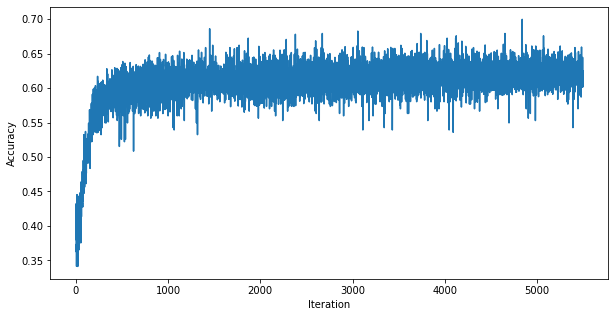

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

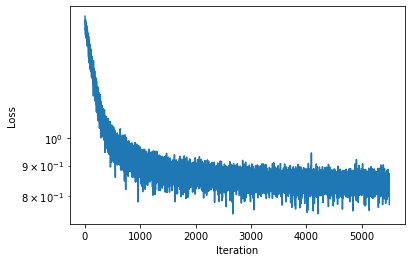

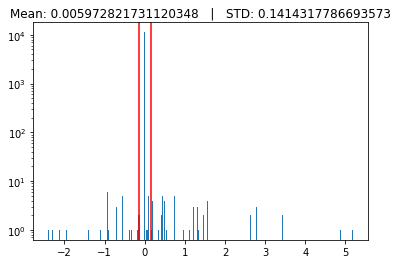

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 4.842105263157895


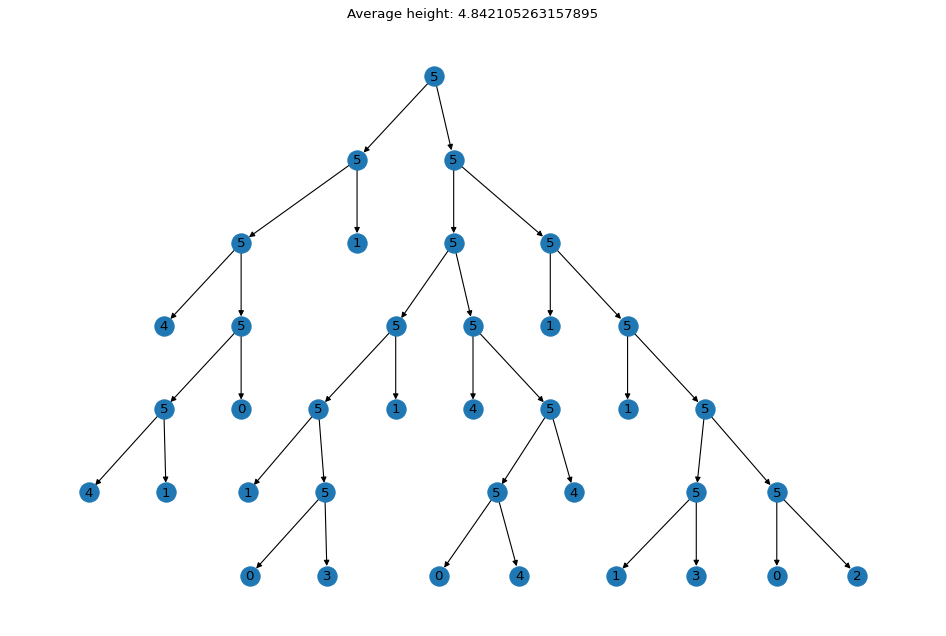

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 19


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
Average comprehensibility: 45.78947368421053


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()